# Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN('table', 'view');
'''

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase

In [2]:
albums_to_purchase = '''
      WITH usa_sold AS
          (
           SELECT il.* FROM invoice_line il
           INNER JOIN invoice i ON i.invoice_id = il.invoice_id
           INNER JOIN customer c ON c.customer_id = i.customer_id
           WHERE c.country = 'USA'       
          )
      SELECT
          g.name Genre_Name,
          COUNT(us.invoice_line_id) tracks_sold,
          CAST(COUNT(us.invoice_line_id) as FLOAT) / ( SELECT COUNT(*) FROM usa_sold
          ) tracks_sold_percent
      FROM usa_sold us
      INNER JOIN track t ON t.track_id = us.track_id
      INNER JOIN genre g ON g.genre_id = t.genre_id
      GROUP BY 1
      ORDER BY 2 DESC LIMIT 10;
'''
run_query(albums_to_purchase)

,Genre_Name,tracks_sold,tracks_sold_percent
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


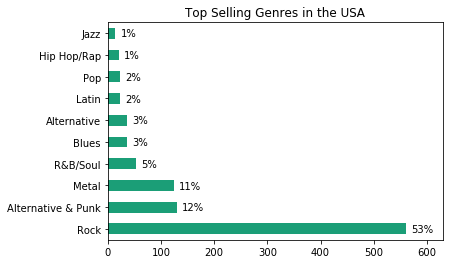

In [3]:
atp = run_query(albums_to_purchase)
atp.set_index('Genre_Name', drop=True, inplace=True)

atp['tracks_sold'].plot.barh(
    title='Top Selling Genres in the USA',
    xlim=(0,630),
    colormap=plt.cm.Dark2
)

plt.ylabel('')

for i, label in enumerate(list(atp.index)):
    score = atp.loc[label, 'tracks_sold']
    label = (atp.loc[label, 'tracks_sold_percent'] * 100).astype(int).astype(str) + '%'
    plt.annotate(label, (score + 10, i - 0.15))
   
plt.show()

We can clearly see that Rock genre makes up more than 50% of the entire sale in the USA. It is followed by Alternative&Punk and Metal, respetively, but the percentages are not siginificant. 

Let's say, we has just signed a deal with a new record label, and I've been tasked with selecting the first three albums that will be added to the store, from a list of four below. All four albums are by artists that don't have any tracks in the store right now -- have the artist names, and the genre of music they produce:

In [4]:
%%html
<style>
table {float:left}
</style>

| Artist Name | Genre   |
|:------|:------|
|   Reg  | Hip-Hop |
|   Blue Tone  | Punk |
|   Meteor and the Boys  | Pop |
|   BQS  | Blues |



Based on sales of tracks from each genre in the USA, we should purchase the new albums by the following artists:

-  Blue Tone(Punk)
-  BQS(Blues)
-  Meteor and the Boys(Pop)

Together, however, these three genres only makes up a few percentage of total sales. Therefore, we need to look out for any album from rock genre, which accounts for 53%.

# Analyzing Employee Sales Performance

In [6]:
employee_total_sales = '''
        WITH customer_total_sales AS
            (
             SELECT 
                 c.first_name || " " || c.last_name customer_name,
                 SUM(i.total) total_sales,
                 c.support_rep_id employee_id
             FROM customer c
             INNER JOIN invoice i ON i.customer_id = c.customer_id
             GROUP BY 1
            )

        SELECT
            e.first_name || " " || e.last_name employee_name,
            e.hire_date,
            SUM(cts.total_sales) employee_total_sales
        FROM customer_total_sales cts
        INNER JOIN employee e ON cts.employee_id = e.employee_id
        GROUP BY 1;
'''
run_query(employee_total_sales)

,employee_name,hire_date,employee_total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


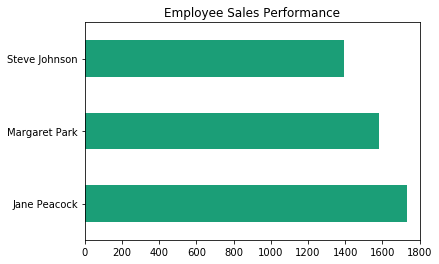

In [10]:
ets = run_query(employee_total_sales)
ets.set_index('employee_name', drop=True, inplace=True)

ets['employee_total_sales'].plot.barh(
    title = 'Employee Sales Performance',
    xlim = (0,1800),
    colormap = plt.cm.Dark2
)
ets.sort_values('employee_total_sales', inplace=True)
plt.ylabel('')

plt.show()

There were only 3 sales support agents at this companyto whom customers are assigned. The analysis above shows that the longer an agent has been working, the more sales performance he or she has.